# Neo4J v1 - Trellis : Coherence check results

- DB for QC : PostgreSQL
- Coherence check includes results generated by FastQC, Samtools Flagstat, and RTG Vcfstats.

------------
## 1.  Setup environment 

### Install

In [1]:
pip install psycopg2-binary

     |████████████████████████████████| 1.6MB 1.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Import Package

In [2]:
from io import StringIO
import time

import pandas as pd
import pandas_gbq

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import storage
import yaml

from google.cloud import bigquery as bq
#import google.datalab.bigquery as bq
import psycopg2

### Setup Account

In [3]:
# Storage bucket
bucket_name = "gbsc-gcp-project-mvp-trellis"
config_blob = "trellis-config.yaml"

In [4]:
# Create storage client
storage_client = storage.Client()
# get bucket with name
bucket = storage_client.get_bucket(bucket_name)
# get bucket data as blob
blob = bucket.get_blob(config_blob)
# convert to string
yaml_data = blob.download_as_string()

account = yaml.load(yaml_data, Loader=yaml.FullLoader)

In [5]:
#print(account["QC_DB_IP"])
#print(account["QC_DB_NAME"])
#print(account["QC_DB_USER"])
#print(account["QC_DB_PASSWORD"])

In [6]:
# Establish connection to databae
conn = psycopg2.connect(
                        host = account["QC_DB_IP"],
                        dbname = account["QC_DB_NAME"],
                        user = account["QC_DB_USER"],
                        password = account["QC_DB_PASSWORD"])

### Check records

In [7]:
# Get number of fastqc records
cursor = conn.cursor()
cursor.execute("SELECT sample, COUNT(*) from fastqc GROUP BY sample")
records = cursor.fetchall()
len(records)

39667

In [8]:
# Get number of flagstat records
cursor = conn.cursor()
cursor.execute("SELECT sample, COUNT(*) from flagstat GROUP BY sample")
records = cursor.fetchall()
len(records)

39745

In [9]:
# Get number of vcfstats records
cursor = conn.cursor()
cursor.execute("SELECT sample, COUNT(*) FROM vcfstats GROUP BY sample")
records = cursor.fetchall()
len(records)

39241

In [10]:
# Get number of contamination records
cursor = conn.cursor()
cursor.execute("SELECT * from check_contamination")
records = cursor.fetchall()
len(records)

40164

### DataFrame Format

In [11]:
# Change list to dataframe for fastqc
cursor = conn.cursor()
cursor.execute("SELECT * from fastqc")
records = cursor.fetchall()
fastqc_df=pd.DataFrame(records)
fastqc_df.columns=['dimension','index','value','data','sample']
fastqc_df.head()

,dimension,index,value,data,sample
0,basic_stats,,pass,phase3,SHIP4954752
1,seq_len,,150,phase3,SHIP4954752
2,gc_content,,41,phase3,SHIP4954752
3,per_base_qual,1,29.736544409207433,phase3,SHIP4954752
4,per_base_qual,2,29.809790628204436,phase3,SHIP4954752


In [12]:
# Change list to dataframe for flagstat
cursor = conn.cursor()
cursor.execute("SELECT * from flagstat")
records = cursor.fetchall()
flagstat_df=pd.DataFrame(records)
flagstat_df.columns=['dimension','index','value','data','sample']
flagstat_df.head()

,dimension,index,value,data,sample
0,qc_passed_reads_count,,605117735,phase3,SHIP4946376
1,qc_failed_reads_count,,0,phase3,SHIP4946376
2,duplicates_count,,47541121,phase3,SHIP4946376
3,mapped_reads_count,,603699167,phase3,SHIP4946376
4,mapped_reads_perc,,99.77,phase3,SHIP4946376


In [13]:
# Change list to dataframe for vcfstats
cursor = conn.cursor()
cursor.execute("SELECT * from vcfstats")
records = cursor.fetchall()
vcfstats_df=pd.DataFrame(records)
vcfstats_df.columns=['dimension','index','value','data','sample']
vcfstats_df.head()

,dimension,index,value,data,sample
0,failed_filters,,0,phase3,SHIP4946367
1,passed_filters,,568276977,phase3,SHIP4946367
2,snps,,4844058,phase3,SHIP4946367
3,insertions,,528166,phase3,SHIP4946367
4,deletions,,552653,phase3,SHIP4946367


In [14]:
# Change list to dataframe for contamination
cursor = conn.cursor()
cursor.execute("SELECT * from check_contamination")
records = cursor.fetchall()
contam_df=pd.DataFrame(records)
contam_df=contam_df[[0,6]]
contam_df.columns=['sample','value']
contam_df.head()

,sample,value
0,SHIP4946367,0.000308484
1,SHIP4962321,0.000223297
2,SHIP4946376,0.000141269
3,SHIP4962334,0.00018697
4,SHIP4946379,0.000120604


------------
## 2.  Fastqc Analysis

### Per Base Quality

In [15]:
#

### GC content

In [16]:
# GC content dataframe
gc_df=fastqc_df.loc[fastqc_df['dimension']=='gc_content',['sample','value']]
gc_df=gc_df.astype({'value': 'int64'})

# Remove duplicated samples
gc_df.drop_duplicates(subset=['sample'],keep='first',inplace=True)

In [17]:
# GC mean
gc_mean=gc_df.value.mean()
print('Mean of GC content: {0:0.2f}'.format(gc_mean))

# GC outlier
gc_df['gc_outlier'] = gc_df.value.apply(lambda x: False if x in [40,41] else True)
gc_outlier_df=gc_df[gc_df['gc_outlier']==True]
num_gc_out=gc_outlier_df.gc_outlier.count()

print('\n'+'Number of GC outliers: {0:0.2f}'.format(num_gc_out))
gc_outlier_df.head()

Mean of GC content: 40.92

Number of GC outliers: 2.00


,sample,value,gc_outlier
30692,SHIP5153248,39,True
1765634,SHIP5630148,42,True


In [18]:
# For Bigquery without duplicated values
bq_gc=gc_df.rename(columns={"value":"gc"})
display(bq_gc.shape[0])
bq_gc.set_index('sample',inplace=True)

39667

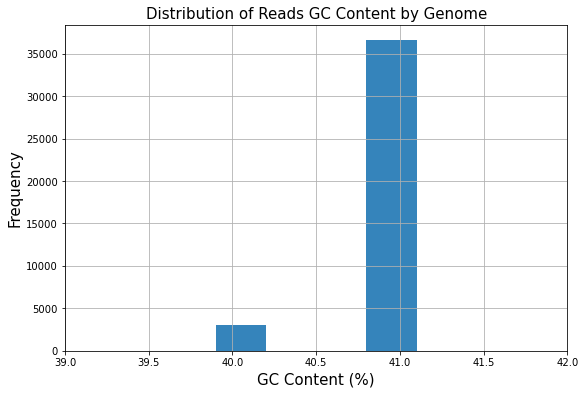

In [19]:
# GC distribution
fig, ax = plt.subplots(figsize=(9,6))
gc_df.value.hist(alpha=0.9, ax=ax, bins=10)
ax.set_xlim(39,42)
#ax.set_ylim(0,250)
ax.set_title("Distribution of Reads GC Content by Genome",size=15)
ax.set_xlabel("GC Content (%)",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### Average sequence quality

In [20]:
# Seq qual dataframe
seq_qual_df=fastqc_df.loc[fastqc_df['dimension']=='seq_quality',['sample','index','value']]
seq_qual_df=seq_qual_df.astype({'index': 'int64','value':'float64'})
seq_qual_df['tot_qual']=np.array(seq_qual_df['index'])*np.array(seq_qual_df['value'])
seq_qual_df.head()

# Average seq qual dataframe
avg_df=seq_qual_df.groupby('sample').sum()
avg_df['avg_seq_qual']=np.array(avg_df['tot_qual'])/np.array(avg_df['value'])

In [21]:
# Average seq qual mean
avg_mean=avg_df.avg_seq_qual.mean()
avg_std=avg_df.avg_seq_qual.std()
print('Mean of Average Seq Quality: {0:0.2f}'.format(avg_mean))
print('Standard Diviation of Average Seq Quality: {0:0.2f}'.format(avg_std))

# SNPS outlier
avg_df['avg_seq_qual_outlier'] = avg_df.avg_seq_qual.apply(lambda x: False if x > 28 else True)
avg_outlier_df=avg_df[avg_df['avg_seq_qual_outlier']==True]
num_avg_out=avg_outlier_df.avg_seq_qual_outlier.count()

print('\n'+'Number of Average Seq Quality outliers: {0:0.0f}'.format(num_avg_out))
avg_outlier_df.head()
#avg_df.head()

Mean of Average Seq Quality: 28.95
Standard Diviation of Average Seq Quality: 0.16

Number of Average Seq Quality outliers: 146


,index,value,tot_qual,avg_seq_qual,avg_seq_qual_outlier
sample,,,,,
SHIP5375675,450,606933378.0,1.698460e+10,27.984288,True
SHIP5375678,450,634489900.0,1.774423e+10,27.966142,True
SHIP5375681,450,507624383.0,1.417059e+10,27.915499,True
SHIP5375683,450,583956872.0,1.633310e+10,27.969709,True
SHIP5375684,450,649073055.0,1.815428e+10,27.969548,True


In [22]:
# For Bigquery without duplicated values
bq_avg_seq_qual=avg_df[['avg_seq_qual','avg_seq_qual_outlier']]
display(bq_avg_seq_qual.shape[0])
bq_avg_seq_qual.head()

39667

,avg_seq_qual,avg_seq_qual_outlier
sample,,
SHIP4946367,28.820686,False
SHIP4946368,28.712868,False
SHIP4946369,28.803914,False
SHIP4946370,28.898697,False
SHIP4946371,28.867003,False


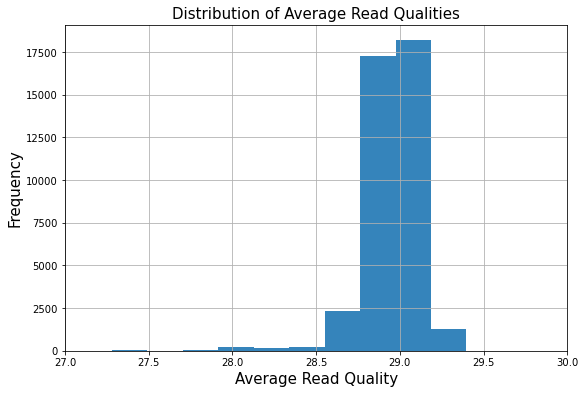

In [23]:
# Average seq qual distribution
fig, ax = plt.subplots(figsize=(9,6))
avg_df.avg_seq_qual.hist(alpha=0.9, ax=ax)
ax.set_xlim(27,30)
ax.set_title("Distribution of Average Read Qualities",size=15)
ax.set_xlabel("Average Read Quality",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### Sequence length

In [24]:
# Seq Length dataframe
seq_len_df=fastqc_df.loc[fastqc_df['dimension']=='seq_len',['sample','value']]
seq_len_df=seq_len_df.astype({'value': 'int64'})

# Remove duplicated samples
seq_len_df.drop_duplicates(subset=['sample'],keep='first',inplace=True)

In [25]:
# Unique lengths
seq_len_counts = seq_len_df.groupby('value')['sample'].nunique()
print (seq_len_counts)

# Seq_len outlier
seq_len_df['seq_len_outlier'] = seq_len_df.value.apply(lambda x: False if x == 150 else True)

value
150    39667
Name: sample, dtype: int64


In [26]:
# For Bigquery without duplicated values
bq_seq_len=seq_len_df.loc[:,['sample','value','seq_len_outlier']].rename(columns={"value":"seq_len"})
display(bq_seq_len.shape[0])
bq_seq_len.set_index('sample',inplace=True)

39667

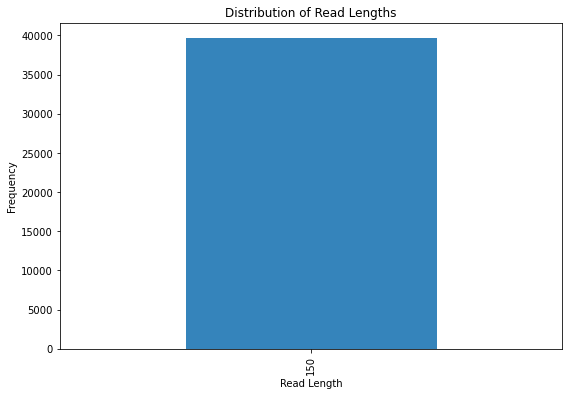

In [27]:
# Seq_len distribution
fig, ax = plt.subplots(figsize=(9,6))
bar = seq_len_counts.plot.bar(alpha=0.9)
ax.set_title("Distribution of Read Lengths")
ax.set_xlabel("Read Length")
ax.set_ylabel("Frequency")
plt.show()

------------
## 3.  RTG VCFstats Analysis

### Filtering

In [28]:
# Filter dataframe
filter_df=vcfstats_df.loc[vcfstats_df['dimension'].isin(['failed_filters', 'passed_filters']),['dimension','sample','value']]
filter_df=filter_df.astype({'value': 'int64'})
filter_df.groupby('dimension')['value'].sum()

dimension
failed_filters                 0
passed_filters    20746602260324
Name: value, dtype: int64

### SNPs

In [29]:
# SNPS dataframe
snps_df=vcfstats_df.loc[vcfstats_df['dimension']=='snps',['sample','value']]
snps_df=snps_df.astype({'value': 'int64'})

# Remove duplicated samples
snps_df.drop_duplicates(subset=['sample'],keep='first',inplace=True)

In [30]:
# SNPS mean
snps_mean=snps_df.value.mean()
snps_std=snps_df.value.std()
print('Mean of SNPS: {0:0.2f}'.format(snps_mean))
print('Standard Diviation of SNPS: {0:0.2f}'.format(snps_std))

# SNPS outlier
snps_df['snps_outlier'] = snps_df.value.apply(lambda x: False if abs(snps_mean-x)<3*snps_std else True)
snps_outlier_df=snps_df[snps_df['snps_outlier']==True]
num_snps_out=snps_outlier_df.snps_outlier.count()

print('\n'+'Number of SNPS outliers: {0:0.0f}'.format(num_snps_out))
snps_outlier_df.head()

Mean of SNPS: 4260053.26
Standard Diviation of SNPS: 345357.15

Number of SNPS outliers: 116


,sample,value,snps_outlier
1397,SHIP5125869,3208154,True
26143,SHIP5183691,2756718,True
40149,SHIP5377977,2949008,True
54623,SHIP5380492,2965848,True
102479,SHIP5884825,2953269,True


In [31]:
# For Bigquery without duplicated samples
bq_snps=snps_df.rename(columns={"value":"snps"})
display(bq_snps.shape[0])
bq_snps.set_index('sample',inplace=True)

39241

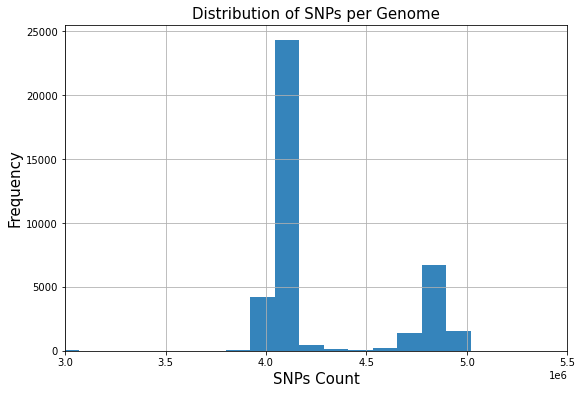

In [32]:
# SNPS distribution
fig, ax = plt.subplots(figsize=(9,6))
hist = snps_df.value.hist(alpha=0.9, ax=ax, bins=20)
ax.set_xlim(3000000,5500000)
ax.set_title("Distribution of SNPs per Genome",size=15)
ax.set_xlabel("SNPs Count",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### Indels

RTG Tools vcfstats outputs data on three categories of indels: insertions, deletions, and indels. From this google group post (https://groups.google.com/a/realtimegenomics.com/forum/#!searchin/rtg-users/vcfstats/rtg-users/-eFsSbWF6ks/1HrnevHTAgAJ):

>For the insertions/deletions/indels the table is based on the delta in length rather than total length (which really matters for the indels):

>Insertions (pure addition of bases)
>A -> AT (length 1 insertion)
>ATT -> ATTTT (length 2 insertion) 

>Deletions (pure deletion of bases)
>AT -> A (length 1 deletion)
>ATTTT -> ATT (length 2 deletion)

>Indels (length changing but not pure)
>ATT -> CTTT (length 1 indel)
>CTTT -> ATT (length 1 indel)"

In [33]:
# Indels dataframe
pre_indels_df=vcfstats_df.loc[vcfstats_df['dimension'].isin(['indels','insertions','deletions']),['dimension','sample','value']]
pre_indels_df=pre_indels_df.astype({'value': 'int64'})

# Remove duplicated samples
pre_indels_df.drop_duplicates(subset=['sample','dimension'],keep='first',inplace=True)

# Accumulate all indels
indels_df=pre_indels_df.groupby('sample')['value'].sum().reset_index()

In [34]:
# Indels mean
indels_mean=indels_df.value.mean()
indels_std=indels_df.value.std()
print('Mean of Indels: {0:0.2f}'.format(indels_mean))
print('Standard Diviation of Indels: {0:0.2f}'.format(indels_std))

# Indels outlier
indels_df['indels_outlier'] = indels_df.value.apply(lambda x: False if abs(indels_mean-x)<3*indels_std else True)
indels_outlier_df=indels_df[indels_df['indels_outlier']==True]
num_indels_out=indels_outlier_df.indels_outlier.count()

print('\n'+'Number of Indels outliers: {0:0.0f}'.format(num_indels_out))
indels_outlier_df.head()

Mean of Indels: 987942.84
Standard Diviation of Indels: 74270.00

Number of Indels outliers: 83


,sample,value,indels_outlier
1152,SHIP5183691,740338,True
5385,SHIP5377977,748304,True
12900,SHIP5523859,757935,True
12901,SHIP5523860,757812,True
20861,SHIP5641545,761518,True


In [35]:
# For Bigquery
bq_indels=indels_df.rename(columns={"value":"indels"})
bq_indels.set_index('sample',inplace=True)
bq_indels.shape[0]

39241

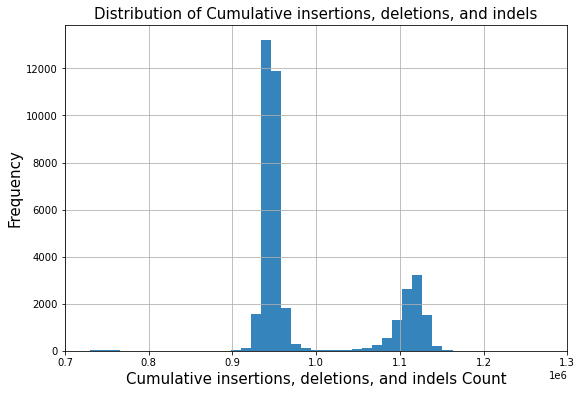

In [36]:
# Indels distribution
fig, ax = plt.subplots(figsize=(9,6))
hist = indels_df.value.hist(alpha=0.9, ax=ax, bins=40)
ax.set_xlim(700000,1300000)
ax.set_title("Distribution of Cumulative insertions, deletions, and indels",size=15)
ax.set_xlabel("Cumulative insertions, deletions, and indels Count",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### Ti/Tv ratio

In [37]:
# Ti/Tv dataframe
titv_df=vcfstats_df.loc[vcfstats_df['dimension']=='ti_tv_ratio',['sample','value']]
titv_df=titv_df.astype({'value': 'float64'})

# Remove duplicated samples
titv_df.drop_duplicates(subset=['sample'],keep='first',inplace=True)

In [38]:
# Ti/Tv mean
titv_mean=titv_df.value.mean()
titv_std=titv_df.value.std()
print('Mean of Ti/Tv ratio: {0:0.2f}'.format(titv_mean))
print('Standard Diviation of Ti/Tv ratio: {0:0.2f}'.format(titv_std))

# Indels outlier
titv_df['titv_outlier'] = titv_df.value.apply(lambda x: False if abs(titv_mean-x)<3*titv_std else True)
titv_outlier_df=titv_df[titv_df['titv_outlier']==True]
num_titv_out=titv_outlier_df.titv_outlier.count()

print('\n'+'Number of Ti/Tv ratio outliers: {0:0.0f}'.format(num_titv_out))
titv_outlier_df.head()

Mean of Ti/Tv ratio: 1.93
Standard Diviation of Ti/Tv ratio: 0.01

Number of Ti/Tv ratio outliers: 398


,sample,value,titv_outlier
15,SHIP4962334,1.97,True
294,SHIP4962322,1.97,True
578,SHIP4948776,1.97,True
888,SHIP5125862,1.99,True
1401,SHIP5125869,1.99,True


In [39]:
# For Bigquery without duplicated samples
bq_titv=titv_df.rename(columns={"value":"ti_tv","titv_outlier":"ti_tv_outlier"}).set_index('sample')
display(bq_titv.shape[0])
bq_titv.head()

39241

,ti_tv,ti_tv_outlier
sample,,
SHIP4946367,1.94,False
SHIP4962334,1.97,True
SHIP4954747,1.95,False
SHIP4946369,1.95,False
SHIP4948534,1.94,False


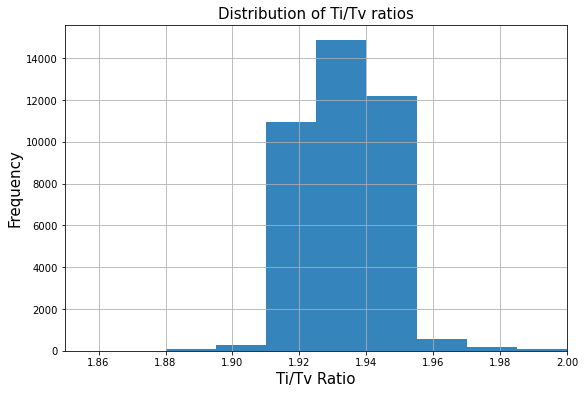

In [40]:
# Ti/Tv ratio distribution
fig, ax = plt.subplots(figsize=(9,6))
hist = titv_df.value.hist(alpha=0.9, ax=ax, bins=8)
ax.set_xlim(1.85,2.0)
ax.set_title("Distribution of Ti/Tv ratios",size=15)
ax.set_xlabel("Ti/Tv Ratio",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### SNP het/hom ratio

In [41]:
# het/hom dataframe
hethom_df=vcfstats_df.loc[vcfstats_df['dimension']=='snp_het_hom_ratio',['sample','value']]
hethom_df=hethom_df.astype({'value': 'float64'})

# Remove duplicated samples
hethom_df.drop_duplicates(subset=['sample'],keep='first',inplace=True)

In [42]:
# het/hom mean
hethom_mean=hethom_df.value.mean()
hethom_std=hethom_df.value.std()
print('Mean of SNP Het/Hom ratio: {0:0.2f}'.format(hethom_mean))
print('Standard Diviation of SNP Het/Hom ratio: {0:0.2f}'.format(hethom_std))

# het/hom outlier
hethom_df['hethom_outlier'] = hethom_df.value.apply(lambda x: False if abs(hethom_mean-x)<3*hethom_std else True)
hethom_outlier_df=hethom_df[hethom_df['hethom_outlier']==True]
num_hethom_out=hethom_outlier_df.hethom_outlier.count()

print('\n'+'Number of SNP Het/Hom ratio outliers: {0:0.0f}'.format(num_hethom_out))
hethom_outlier_df.head()

Mean of SNP Het/Hom ratio: 1.77
Standard Diviation of SNP Het/Hom ratio: 0.21

Number of SNP Het/Hom ratio outliers: 135


,sample,value,hethom_outlier
1403,SHIP5125869,0.96,True
26149,SHIP5183691,0.31,True
40155,SHIP5377977,0.46,True
45395,SHIP5375874,2.48,True
54629,SHIP5380492,0.63,True


In [43]:
# For Bigquery
bq_hethom=hethom_df.rename(columns={"value":"het_hom","hethom_outlier":"het_hom_outlier"}).set_index('sample')
display(bq_hethom.shape[0])
bq_hethom.head()

39241

,het_hom,het_hom_outlier
sample,,
SHIP4946367,2.07,False
SHIP4962334,2.07,False
SHIP4954747,2.09,False
SHIP4946369,2.23,False
SHIP4948534,2.11,False


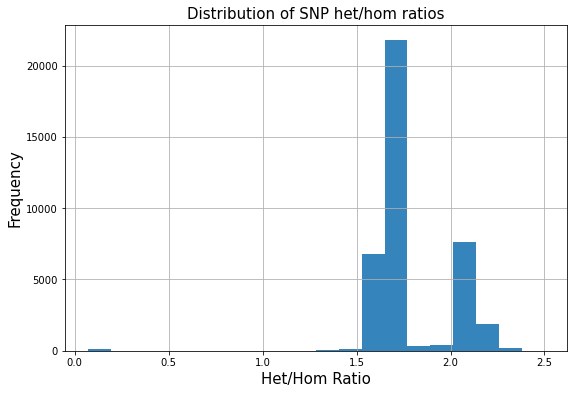

In [44]:
# het/hom ratio distribution
fig, ax = plt.subplots(figsize=(9,6))
hist = hethom_df.value.hist(alpha=0.9, ax=ax, bins=20)
ax.set_title("Distribution of SNP het/hom ratios",size=15)
ax.set_xlabel("Het/Hom Ratio",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

------------
## 4.  Samtools Flagstat Analysis

### Reads mapped to reference

In [45]:
# total read dataframe
total_cnt_df=flagstat_df.loc[flagstat_df['dimension']=='qc_passed_reads_count',['sample','value']]
total_cnt_df=total_cnt_df.astype({'value': 'float64'})

# Remove duplicated samples
total_cnt_df.drop_duplicates(subset=['sample'],keep='first',inplace=True)
display(total_cnt_df.shape[0])
total_cnt_df=total_cnt_df.rename(columns={"value":"total_cnt"}).set_index('sample')

39745

In [46]:
# mapped read dataframe
mapped_cnt_df=flagstat_df.loc[flagstat_df['dimension']=='mapped_reads_count',['sample','value']]
mapped_cnt_df=mapped_cnt_df.astype({'value': 'float64'})

# Remove duplicated samples
mapped_cnt_df.drop_duplicates(subset=['sample','value'],keep='first',inplace=True)
display(mapped_cnt_df.shape[0])

mapped_cnt_df=mapped_cnt_df.rename(columns={"value":"mapped_cnt"}).set_index('sample')

39745

In [47]:
# mapped percent dataframe
mapped_pct_df=total_cnt_df.join(mapped_cnt_df)
mapped_pct_df['mapped_pct']=100*(mapped_pct_df['mapped_cnt']/mapped_pct_df['total_cnt'])
mapped_pct_df['total_cnt']=mapped_pct_df.total_cnt.astype(int)
mapped_pct_df['mapped_cnt']=mapped_pct_df.mapped_cnt.astype(int)
mapped_pct_df['mapped_pct']=mapped_pct_df.mapped_pct.astype(float).round(2)

In [48]:
# mapped percent mean and std
mapped_pct_mean=mapped_pct_df.mapped_pct.mean()
mapped_pct_std=mapped_pct_df.mapped_pct.std()

print('Mean of the mapped read percentage : {0:0.2f}'.format(mapped_pct_mean))
print('Standard Diviation of the mapped read percentage: {0:0.2f}'.format(mapped_pct_std))

# mapped percent
mapped_pct_df['mapped_pct_outlier'] = mapped_pct_df.mapped_pct.apply(lambda x: False if x > 98 else True)
mapped_pct_outlier_df=mapped_pct_df[mapped_pct_df['mapped_pct_outlier']==True]
num_mapped_pct_out=mapped_pct_outlier_df.mapped_pct_outlier.count()

print('\n'+'Number of mapped read percentage outliers: {0:0.0f}'.format(num_mapped_pct_out))
mapped_pct_outlier_df.head()

Mean of the mapped read percentage : 99.78
Standard Diviation of the mapped read percentage: 0.06

Number of mapped read percentage outliers: 0


,total_cnt,mapped_cnt,mapped_pct,mapped_pct_outlier
sample,,,,


In [49]:
# For Bigquery
bq_mapped_pct=mapped_pct_df.loc[:,['mapped_pct','mapped_pct_outlier']]
bq_mapped_pct.head()

,mapped_pct,mapped_pct_outlier
sample,,
SHIP4946376,99.77,False
SHIP4962334,99.83,False
SHIP4962321,99.80,False
SHIP4962335,99.82,False
SHIP4962330,99.82,False


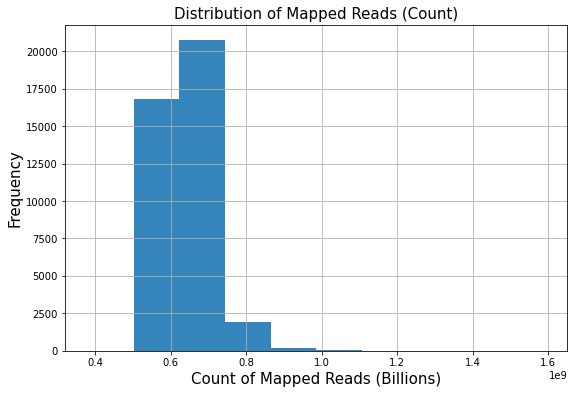

In [50]:
# mapped read cnt distribution
fig, ax = plt.subplots(figsize=(9,6))
hist = mapped_pct_df.mapped_cnt.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Mapped Reads (Count)",size=15)
ax.set_xlabel("Count of Mapped Reads (Billions)",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

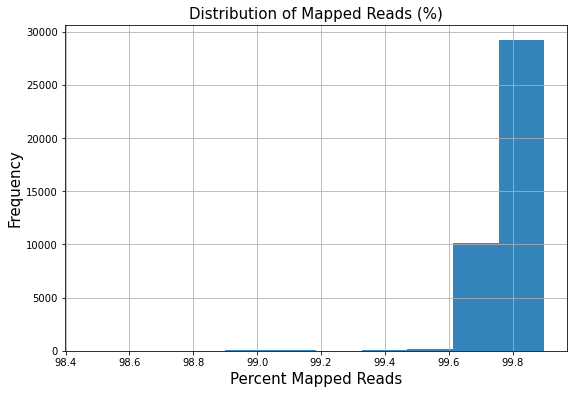

In [51]:
# mapped read pct distribution
fig, ax = plt.subplots(figsize=(9,6))
hist = mapped_pct_df.mapped_pct.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Mapped Reads (%)",size=15)
ax.set_xlabel("Percent Mapped Reads",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### Reads properly paired

In [52]:
# properly paired read dataframe
paired_cnt_df=flagstat_df.loc[flagstat_df['dimension']=='properly_paired_count',['sample','value']]
paired_cnt_df=paired_cnt_df.astype({'value': 'float64'})

# Remove duplicated samples
paired_cnt_df.drop_duplicates(subset=['sample'],keep='first',inplace=True)
display(paired_cnt_df.shape[0])

paired_cnt_df=paired_cnt_df.rename(columns={"value":"paired_cnt"}).set_index('sample')

39745

In [53]:
# properly paired percent dataframe
paired_pct_df=total_cnt_df.join(paired_cnt_df)
paired_pct_df['paired_pct']=100*(paired_pct_df['paired_cnt']/paired_pct_df['total_cnt'])
paired_pct_df['total_cnt']=paired_pct_df.total_cnt.astype(int)
paired_pct_df['paired_cnt']=paired_pct_df.paired_cnt.astype(int)
paired_pct_df['paired_pct']=paired_pct_df.paired_pct.astype(float).round(2)

In [54]:
# properly paired percent mean and std
paired_pct_mean=paired_pct_df.paired_pct.mean()
paired_pct_std=paired_pct_df.paired_pct.std()

print('Mean of the properly paired read percentage : {0:0.2f}'.format(paired_pct_mean))
print('Standard Diviation of the properly paired read percentage: {0:0.2f}'.format(paired_pct_std))

# properly paired read percent outlier
paired_pct_df['paired_pct_outlier'] = paired_pct_df.paired_pct.apply(lambda x: False if x > 95 else True)
paired_pct_outlier_df=paired_pct_df[paired_pct_df['paired_pct_outlier']==True]
num_paired_pct_out=paired_pct_outlier_df.paired_pct_outlier.count()

print('\n'+'Number of properly paired read percentage outliers: {0:0.0f}'.format(num_paired_pct_out))
paired_pct_outlier_df.head()

Mean of the properly paired read percentage : 95.98
Standard Diviation of the properly paired read percentage: 0.43

Number of properly paired read percentage outliers: 890


,total_cnt,paired_cnt,paired_pct,paired_pct_outlier
sample,,,,
SHIP5169522,805591215,764865198,94.94,True
SHIP5462564,680626884,646171794,94.94,True
SHIP5462584,636307093,603847564,94.90,True
SHIP5462575,616417554,583241437,94.62,True
SHIP5462560,651084255,616299461,94.66,True


In [55]:
# For Bigquery
bq_paired_pct=paired_pct_df.loc[:,['paired_pct','paired_pct_outlier']]
bq_paired_pct.head()

,paired_pct,paired_pct_outlier
sample,,
SHIP4946376,96.47,False
SHIP4962334,95.82,False
SHIP4962321,96.07,False
SHIP4962335,95.63,False
SHIP4962330,96.16,False


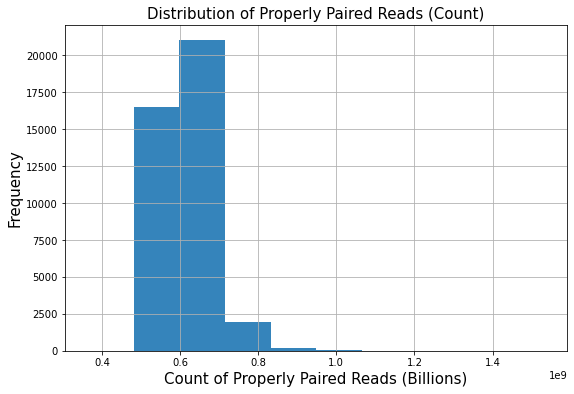

In [56]:
# properly paired read cnt distribution
fig, ax = plt.subplots(figsize=(9,6))
hist = paired_pct_df.paired_cnt.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (Count)",size=15)
ax.set_xlabel("Count of Properly Paired Reads (Billions)",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

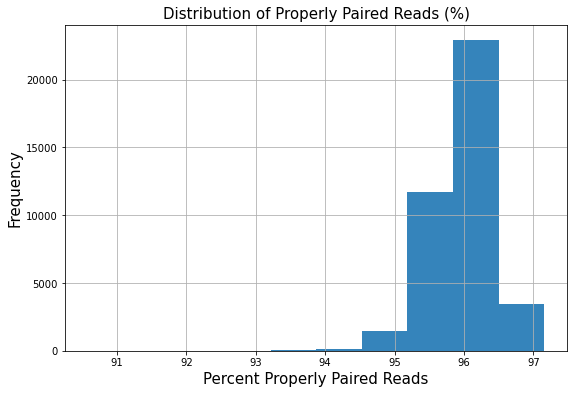

In [57]:
# properly paired read pct distribution
fig, ax = plt.subplots(figsize=(9,6))
hist = paired_pct_df.paired_pct.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (%)",size=15)
ax.set_xlabel("Percent Properly Paired Reads",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

------------
## 5. VerifyBamID Analysis

### check_contamination

In [58]:
# check_contamination dataframe
contam_df=contam_df.astype({'value': 'float64'})

# Remove duplicated samples
contam_df.drop_duplicates(subset=['sample'],keep='first',inplace=True)
display(contam_df.shape[0])

contam_df=contam_df.rename(columns={"value":"contam_rate"}).set_index('sample')

40077

In [59]:
# check_contamination outlier
contam_df.loc[contam_df.contam_rate < 0.05, 'contam_rate_outlier']=False
contam_df.loc[contam_df.contam_rate >= 0.05, 'contam_rate_outlier']=True

contam_outlier_df=contam_df[contam_df['contam_rate_outlier']==True]
num_contam_out=contam_outlier_df.contam_rate_outlier.count()

print('\n'+'Number of contamination rate outliers: {0:0.0f}'.format(num_contam_out))
contam_outlier_df.head()


Number of contamination rate outliers: 361


,contam_rate,contam_rate_outlier
sample,,
SHIP5125869,0.250337,True
SHIP5125862,0.210448,True
SHIP5153292,0.094646,True
SHIP5183694,0.068049,True
SHIP5153295,0.072433,True


In [60]:
# For Bigquery
bq_contam=contam_df

Text(0, 0.5, 'Frequency')

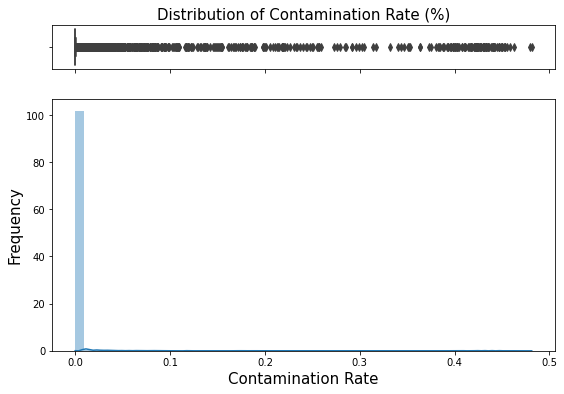

In [61]:
# check_contamination box plot and distribution

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9,6))
 
# Add a graph in each part
sns.boxplot(contam_df["contam_rate"], ax=ax_box)
sns.distplot(contam_df["contam_rate"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title("Distribution of Contamination Rate (%)",size=15)
ax_hist.set_xlabel("Contamination Rate",size=15)
ax_hist.set_ylabel("Frequency",size=15)

------------
## 6. Generate QC Bigquery table

In [62]:
# display(bq_gc.shape[0])
# display(bq_seq_len.shape[0])
# display(bq_snps.shape[0])
# display(bq_indels.shape[0])
# display(bq_titv.shape[0])
# display(bq_hethom.shape[0])
# display(bq_mapped_pct.shape[0])
# display(bq_paired_pct.shape[0])
# display(bq_contam.shape[0])

In [63]:
#bq_gc.head()
#bq_seq_len.head()
#bq_snps.head()
#bq_indels.head()
#bq_titv.head()
#bq_hethom.head()
#bq_mapped_pct.head()
#bq_paired_pct.head()
#bq_contam.head()

### Merge all QC features

In [64]:
bq_qc=bq_gc.merge(bq_avg_seq_qual, how='outer',left_index=True,right_index=True) \
     .merge(bq_seq_len, how='outer',left_index=True,right_index=True) \
     .merge(bq_snps, how='outer',left_index=True,right_index=True) \
     .merge(bq_indels, how='outer',left_index=True,right_index=True) \
     .merge(bq_titv, how='outer',left_index=True,right_index=True) \
     .merge(bq_hethom, how='outer',left_index=True,right_index=True) \
     .merge(bq_mapped_pct, how='outer',left_index=True,right_index=True) \
     .merge(bq_paired_pct, how='outer',left_index=True,right_index=True) \
     .merge(bq_contam, how='outer',left_index=True,right_index=True)
bq_qc.reset_index(inplace=True)
display(bq_qc.shape[0])

40095

### Add outlier list

In [65]:
## pass
bq_qc['outlier']='pass'

## fail check
bq_qc.loc[(bq_qc['gc_outlier']==True)|(bq_qc['avg_seq_qual_outlier']==True)|(bq_qc['seq_len_outlier']==True) \
          |(bq_qc['snps_outlier']==True)|(bq_qc['indels_outlier']==True)|(bq_qc['ti_tv_outlier']==True) \
          |(bq_qc['het_hom_outlier']==True)|(bq_qc['mapped_pct_outlier']==True)|(bq_qc['paired_pct_outlier']==True) \
          |(bq_qc['contam_rate_outlier']==True),'outlier']='outlier'

## outlier
bq_qc.loc[(bq_qc['gc_outlier'].isna())|(bq_qc['avg_seq_qual_outlier'].isna())|(bq_qc['seq_len_outlier'].isna()) \
          |(bq_qc['snps_outlier'].isna())|(bq_qc['indels_outlier'].isna())|(bq_qc['ti_tv_outlier'].isna()) \
          |(bq_qc['het_hom_outlier'].isna())|(bq_qc['mapped_pct_outlier'].isna())|(bq_qc['paired_pct_outlier'].isna()) \
          |(bq_qc['contam_rate_outlier'].isna()),'outlier']='uncompleted'

bq_qc=bq_qc[['sample','outlier', 'gc', 'gc_outlier', 'avg_seq_qual', 'avg_seq_qual_outlier',
       'seq_len', 'seq_len_outlier', 'snps', 'snps_outlier', 'indels',
       'indels_outlier', 'ti_tv', 'ti_tv_outlier', 'het_hom',
       'het_hom_outlier', 'mapped_pct', 'mapped_pct_outlier', 'paired_pct',
       'paired_pct_outlier', 'contam_rate', 'contam_rate_outlier']]

### Outlier and uncompleted lists

In [66]:
bq_qc.loc[bq_qc['outlier']=='outlier',:].to_csv('gs://'+account['TRELLIS_BUCKET']+'/analysis-notebooks/qc_outlier.csv')
bq_qc.loc[bq_qc['outlier']=='uncompleted',:].to_csv('gs://'+account['TRELLIS_BUCKET']+'/analysis-notebooks/qc_uncompleted.csv')

### Upload DF to BigQuery

In [67]:
table_id=account['BIGQUERY_DATASET']+'.qc_analysis'
projectid=account['GOOGLE_CLOUD_PROJECT']

pandas_gbq.to_gbq(
    bq_qc, table_id, project_id=projectid, if_exists='replace',
)

1it [00:06,  6.82s/it]


In [68]:
bq_qc.head()

,sample,outlier,gc,gc_outlier,avg_seq_qual,avg_seq_qual_outlier,seq_len,seq_len_outlier,snps,snps_outlier,...,ti_tv,ti_tv_outlier,het_hom,het_hom_outlier,mapped_pct,mapped_pct_outlier,paired_pct,paired_pct_outlier,contam_rate,contam_rate_outlier
0,SHIP4946367,pass,41.0,False,28.820686,False,150.0,False,4844058.0,False,...,1.94,False,2.07,False,99.80,False,96.07,False,0.000308,False
1,SHIP4946368,pass,41.0,False,28.712868,False,150.0,False,4874085.0,False,...,1.94,False,2.11,False,99.76,False,95.98,False,0.000312,False
2,SHIP4946369,pass,41.0,False,28.803914,False,150.0,False,4898993.0,False,...,1.95,False,2.23,False,99.78,False,96.37,False,0.000388,False
3,SHIP4946370,pass,41.0,False,28.898697,False,150.0,False,4882008.0,False,...,1.95,False,2.09,False,99.80,False,96.35,False,0.000163,False
4,SHIP4946371,pass,41.0,False,28.867003,False,150.0,False,4868496.0,False,...,1.95,False,2.04,False,99.80,False,96.57,False,0.000454,False
